In [51]:
import nltk
from nltk.corpus import wordnet as wn
from search_utils import load_queries_relevants, get_abstract_queries
import numpy as np
from typing import List, Union
from scipy.stats import ttest_ind, mannwhitneyu
import warnings
from ds_utils import get_coco_caption
from tqdm.auto import tqdm
warnings.simplefilter("ignore")

In [52]:
ss = wn.synsets('singed')[2]

In [53]:
ss.hypernyms()

[Synset('interpret.v.03'), Synset('sing.v.02')]

In [54]:
coco_caps = get_coco_caption()

Reading the zip file


In [55]:
with open('../vg_subset.txt', 'rt') as f:
    valid = [int(l.strip()) for l in f]
    
coco_caps = {i: coco_caps[i] for i in valid}

In [56]:
caps = []
for c in coco_caps.values():
    caps.extend(c)
    
coco_caps = caps
del caps

In [57]:
def concept_deep(synset):
    deep = float('inf')
    for h in synset.hypernyms():
        c_deep = concept_deep(h)
        if c_deep < deep:
            deep = c_deep
    if deep == float('inf'):
        return 1
    return deep + 1

In [58]:
q, _, _ = load_queries_relevants()
abq = get_abstract_queries() 

In [59]:
def deep_text(text: str, merge=lambda x: x if len(x) > 0 else None, show_missing=False) -> List[Union[int, float, None]]:
    res = []
    for q in text.replace('.', '').split(' '):
        ss = merge([concept_deep(x) for x in wn.synsets(q)])
        if ss is None and not show_missing:
            continue
        res.append(ss)
    return res

In [60]:
q_d = {i: deep_text(t, merge=lambda x: np.mean(x) if len(x) > 0 else None) for i, t in q.items()}
coco_process = [deep_text(c, merge=lambda x: np.mean(x) if len(x) > 0 else None) for c in tqdm(coco_caps)] 

  0%|          | 0/217184 [00:00<?, ?it/s]

In [61]:
a = []
na = []
for i, d in q_d.items():
    if i in abq:
        a.append(np.min(d))
    else:
        na.append(np.min(d))

coco = [np.min(c) for c in coco_process] 
print(f'Conceptual: {np.mean(a)} +/- {np.std(a)}')
print(f'Descriptive: {np.mean(na)} +/- {np.std(na)}')
print(f'MS-COCO: {np.mean(coco)} +/- {np.std(coco)}')

Conceptual: 2.9628666971019912 +/- 1.9359254099251073
Descriptive: 3.562740987083093 +/- 2.3000288877664046
MS-COCO: 1.528444333446497 +/- 0.8880466622005423


In [62]:
a = []
na = []
for i, d in q_d.items():
    if i in abq:
        a.append(np.mean(d))
    else:
        na.append(np.mean(d))
        
coco = [np.mean(c) for c in coco_process] 
print(f'Conceptual: {np.mean(a)} +/- {np.std(a)}')
print(f'Descriptive: {np.mean(na)} +/- {np.std(na)}')
print(f'MS-COCO: {np.mean(coco)} +/- {np.std(coco)}')

Conceptual: 4.878433537797921 +/- 1.5675907803977542
Descriptive: 5.98580567930426 +/- 1.34579772141604
MS-COCO: 5.745895125281062 +/- 0.9288995264839578


In [63]:
na = 0
nac = 0
a = 0
ac = 0

for i, d in q_d.items():
    if i in abq:
        a += np.max(d)
        ac += 1
    else:
        na += np.max(d)
        nac += 1
        
coco = [np.max(c) for c in coco_process] 
print(f'Conceptual: {np.mean(a)} +/- {np.std(a)}')
print(f'Descriptive: {np.mean(na)} +/- {np.std(na)}')
print(f'MS-COCO: {np.mean(coco)} +/- {np.std(coco)}')

Conceptual: 336.38463448316395 +/- 0.0
Descriptive: 240.95714285714288 +/- 0.0
MS-COCO: 9.724768577676805 +/- 1.5266809579460967


# Abstraction with classifiers

In [64]:
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import matplotlib.pyplot as plt


class SentenceTransformerClassifier:
    
    def __init__(self, model='all-mpnet-base-v2', softmax=True):
        self.model = SentenceTransformer(model)
        self.softmax = softmax
    
    def __call__(self, sentences, candidate_labels):
        enc_labels = self.model.encode(candidate_labels)
        enc_sentences = self.model.encode(sentences)
        if not self.softmax:
            return enc_sentences @ enc_labels.T
        res = np.exp(enc_sentences @ enc_labels.T)
        #m = np.min(res, axis=1, keepdims=True)
        #mx = np.max(res, axis=1, keepdims=True)
        #res = (res - m) / (mx - m) + 1e-6
        return res / np.sum(res, axis=-1, keepdims=True)#[:, np.newaxis]
    

def sorted_pred(pred, ids):
    sort = np.zeros((len(ids),))
    for s, l in zip(pred['scores'], pred['labels']):
        sort[ids[l]] = s
    return sort

#'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli'
class PipelineClassifier:
    
    def __init__(self, model='facebook/bart-large-mnli', device=-1):
        self.classifier = pipeline('zero-shot-classification', model=model, device=device)	
    
    def __call__(self, sentences, candidate_labels):
        id_candidate = {c: i for i, c in enumerate(candidate_labels)}
        return [sorted_pred(score, id_candidate) for score in self.classifier(sentences, candidate_labels=candidate_labels, batch_size=40)]

In [65]:
def entropy(x, dim=-1):
    if type(x) == list:
        x = np.asarray(x)
    return np.sum(-x * np.log2(x), axis=dim)

def perplexity(x, dim=-1):
    if type(x) == list:
        x = np.asarray(x)
    return 2 ** entropy(x, dim=-1)


def evaluate(queries, candidate_labels, classifier, compute_perplexity=True):
    ids, q = list(queries.keys()), list(queries.values())
    scores = classifier(q, candidate_labels)
    scores = {i: c for i, c in zip(ids, scores)}
    a = []
    na = []
    for i, d in scores.items():
        if i in abq:
            a.append(d)
        else:
            na.append(d)

    a = np.asarray(a)
    na = np.asarray(na)
    plt.imshow(a)
    plt.show()
    plt.imshow(na)
    plt.show()
    print(f'Abstract max {np.mean([np.max(x) for x in a])} +/- {np.std([np.max(x) for x in a])}')
    print(f'Concrete max {np.mean([np.max(x) for x in na])} +/- {np.std([np.max(x) for x in na])}')
    print(ttest_ind([np.max(x) for x in a], [np.max(x) for x in na], alternative='less'))
    print(mannwhitneyu([np.max(x) for x in a], [np.max(x) for x in na], alternative='less'))
    if compute_perplexity:
        pa = perplexity(a)
        pna = perplexity(na)
        print(f'Abstract perplex {np.mean(pa)} +/- {np.std(pa)}')
        print(f'Concrete perplex {np.mean(pna)} +/- {np.std(pna)}')
        print(ttest_ind(pa, pna, alternative='greater'))
        print(mannwhitneyu(pa, pna, alternative='greater'))
    pass

In [66]:

ml = PipelineClassifier(model='MoritzLaurer/mDeBERTa-v3-base-mnli-xnli', device=0)
fc = PipelineClassifier(device=0)


In [67]:
candidate_labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

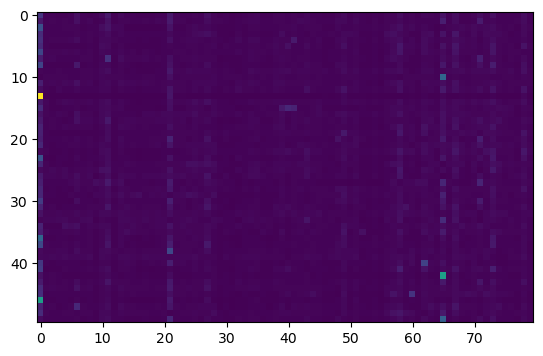

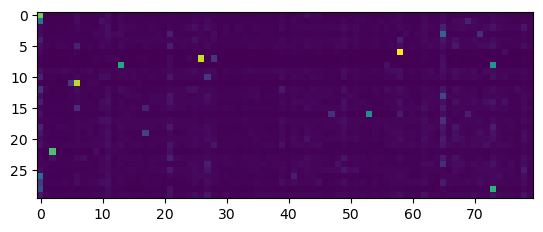

Abstract max 0.10569157738238573 +/- 0.1011755560410259
Concrete max 0.2004464919368426 +/- 0.19020131135581048
Ttest_indResult(statistic=-2.8673505806132518, pvalue=0.0026603326389679155)
MannwhitneyuResult(statistic=568.0, pvalue=0.035634351729875606)
Abstract perplex 62.16781954073612 +/- 12.335623709642563
Concrete perplex 50.01441430397173 +/- 23.108672574314824
Ttest_indResult(statistic=3.02361140009213, pvalue=0.0016898588056275896)
MannwhitneyuResult(statistic=950.0, pvalue=0.023703440125268677)


In [68]:
evaluate(q, candidate_labels, ml)

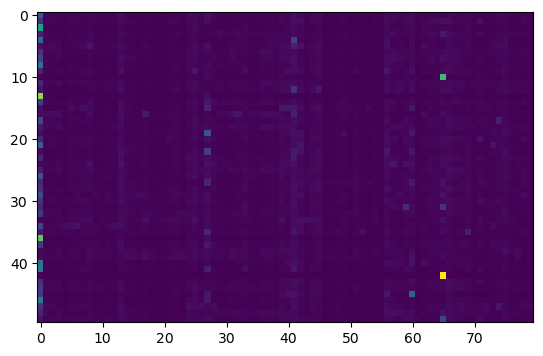

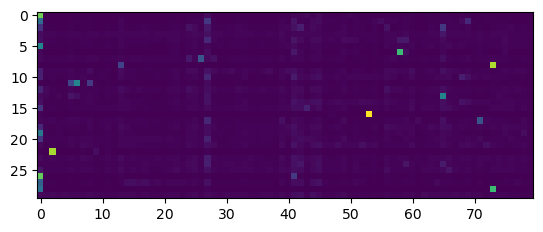

Abstract max 0.18017554450780154 +/- 0.16104128786894925
Concrete max 0.27775556929409506 +/- 0.244429449449262
Ttest_indResult(statistic=-2.123213940196599, pvalue=0.018453417194682402)
MannwhitneyuResult(statistic=635.0, pvalue=0.12757900156906626)
Abstract perplex 51.2196681750979 +/- 17.139533040097735
Concrete perplex 40.74472591665856 +/- 24.656603113125712
Ttest_indResult(statistic=2.2076284709451897, pvalue=0.015104389980142473)
MannwhitneyuResult(statistic=891.0, pvalue=0.08131205290032129)


In [69]:
evaluate(q, candidate_labels, fc)

In [70]:
candidate_labels = ['accessory', 'animal', 'appliance', 'electronic', 'food', 'furniture', 'indoor', 'kitchen', 'outdoor', 'person', 'sports', 'vehicle']

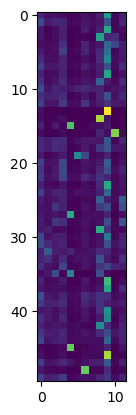

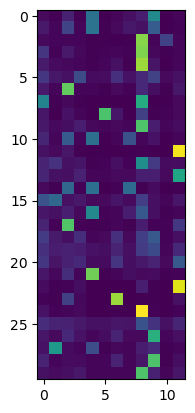

Abstract max 0.3858032250404358 +/- 0.1907439192695509
Concrete max 0.5156457056601842 +/- 0.20193848954154378
Ttest_indResult(statistic=-2.846733587927519, pvalue=0.0028211811639505817)
MannwhitneyuResult(statistic=476.0, pvalue=0.0032832483023656654)
Abstract perplex 7.367883929166002 +/- 2.4234276208582153
Concrete perplex 5.193373631669496 +/- 2.401568081669031
Ttest_indResult(statistic=3.8494767086210677, pvalue=0.00012045424419711665)
MannwhitneyuResult(statistic=1098.0, pvalue=0.00027669883193198123)


In [71]:
evaluate(q, candidate_labels, ml)

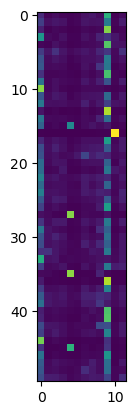

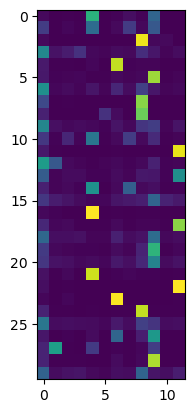

Abstract max 0.48451962500810625 +/- 0.19582188093439143
Concrete max 0.6204651296138763 +/- 0.22272390864361877
Ttest_indResult(statistic=-2.817234970570266, pvalue=0.0030669046231349144)
MannwhitneyuResult(statistic=480.0, pvalue=0.0036997069919010284)
Abstract perplex 5.677534274447282 +/- 2.1857919973365014
Concrete perplex 3.9770975539451 +/- 2.1725388357161752
Ttest_indResult(statistic=3.333813548623773, pvalue=0.0006562664671485097)
MannwhitneyuResult(statistic=1077.0, pvalue=0.0005877006068250104)


In [72]:
evaluate(q, candidate_labels, fc)